In [36]:
import os, os.path
import numpy as np
import pandas as pd
import model_attributes as ma
from attribute_table import AttributeTable
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_energy as me
import model_electricity as ml
import model_socioeconomic as se
from model_socioeconomic import Socioeconomic
import setup_analysis as sa
import support_functions as sf
import importlib
import time
import warnings
import matplotlib.pyplot as plt

importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
importlib.reload(ml)


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:1943: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  


<module 'model_electricity' from '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_electricity.py'>

In [37]:
#########################################################################################################################
###                                                                                                                   ###
###    BUILD BASIC ENERGY COSTS FROM EIA PDF (orig. https://www.eia.gov/outlooks/aeo/assumptions/pdf/table_8.2.pdf)   ###
###                                                                                                                   ###
#########################################################################################################################


fp_read = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/data_tables_and_derivations/ENERGY/eia_outlooks_table_8.2.xlsx"
df_eia = pd.read_excel(fp_read, skiprows = 1).rename(columns = {
    "Unnamed: 0": "tech", 
    "Unnamed: 1": "year_start",
    "Total Overnight Cost (2021$/kW)": "capital_cost",
    "Variable O&M (2021 $/MWh)": "variable_cost", 
    "Fixed O&M 2021$/kW-y)": "fixed_cost"
})

fields_group = ["cat_technology"]
fields_mean = [f"{x}_cost" for x in ["capital", "variable", "fixed"]]

dict_agg = dict(zip(fields_group, ["first" for x in fields_group]))
dict_agg.update(dict(zip(fields_mean, ["mean" for x in fields_mean])))

df_eia = df_eia.groupby(fields_group).agg(dict_agg).reset_index(drop = True).sort_values(by = ["cat_technology"])
df_eia.to_csv("/Users/jsyme/Desktop/tmp.csv", index = None, encoding = "UTF-8")

In [38]:
########################################################
###                                                  ###
###    BUILD NEMOMOD ReserveCapacity INITIAL DATA    ###
###                                                  ###
########################################################

# get data 
fp_data = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/LAC_global_power_plant_database.csv"
df_data = pd.read_csv(fp_data)
if False:
    df_data.dropna(
        how = "all", 
        subset = ["estimated_generation_gwh_2017", "estimated_generation_gwh_2016", "estimated_generation_gwh_2015", "estimated_generation_gwh_2014", "estimated_generation_gwh_2013"],
        inplace = True
    )

# assumed lifetimes (baseline) - add sources to attribute table
dict_lifetimes = {
    "Biomass": 25, # https://www.nrel.gov/analysis/tech-footprint.html
    "Other": 50, 
    "Gas": 25, # 22, but set to 25 https://www.eia.gov/todayinenergy/detail.php?id=34172
    "Hydro": 100, # https://www.nrel.gov/docs/fy04osti/34916.pdf
    "Oil": 40, 
    "Nuclear": 30, # https://www.iaea.org/sites/default/files/29402043133.pdf
    "Coal": 50, # https://www.nature.com/articles/s41467-019-12618-3
    "Solar": 30, # https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiExIeGvL35AhVPKkQIHR1ABJMQFnoECBsQAw&url=https%3A%2F%2Fnews.energysage.com%2Fhow-long-do-solar-panels-last%2F&usg=AOvVaw0rJ8w3zaBIP4b83sJgsKcr
    "Wind": 20, # https://nepis.epa.gov/Exe/ZyNET.exe/P100IL8K.TXT?ZyActionD=ZyDocument&Client=EPA&Index=2011+Thru+2015&Docs=&Query=&Time=&EndTime=&SearchMethod=1&TocRestrict=n&Toc=&TocEntry=&QField=&QFieldYear=&QFieldMonth=&QFieldDay=&IntQFieldOp=0&ExtQFieldOp=0&XmlQuery=&File=D%3A%5Czyfiles%5CIndex%20Data%5C11thru15%5CTxt%5C00000010%5CP100IL8K.txt&User=ANONYMOUS&Password=anonymous&SortMethod=h%7C-&MaximumDocuments=1&FuzzyDegree=0&ImageQuality=r75g8/r75g8/x150y150g16/i425&Display=hpfr&DefSeekPage=x&SearchBack=ZyActionL&Back=ZyActionS&BackDesc=Results%20page&MaximumPages=1&ZyEntry=1&SeekPage=x&ZyPURL
    "Waste": 30, # https://www.pbs.org/newshour/science/is-burning-trash-a-good-way-to-dispose-of-it-waste-incineration-in-charts,
    "Geothermal": 30, # https://geothermal-energy-journal.springeropen.com/articles/10.1186/s40517-021-00183-2
    "Ocean": 25 # assume 25, nascent tech
}

# real lifetimes are available here
attr_entc = sa.model_attributes.get_attribute_table(sa.model_attributes.subsec_name_entc)
dict_lifetimes = attr_entc.field_maps.get("cat_technology_to_operational_life")


# FOR PURPOSES OF INITIAL STATES, SET PETCOKE TO COAL
if len(df_data[df_data["primary_fuel"] == "Petcoke"]) == 1:
    df_data["primary_fuel"] = df_data["primary_fuel"].replace({"Petcoke": "Coal"})
    
# FOR OTHER POWER PLANTS, USE SECONDARY
if len(df_data["primary_fuel"][df_data["primary_fuel"] == "Other"]) > 0:
    inds = df_data[df_data["primary_fuel"] == "Other"].index
    
    for i in inds:
        if df_data["other_fuel1"].iloc[i] not in [np.nan, "Other", "Petcoke"]:
            df_data["primary_fuel"].iloc[i] = df_data["other_fuel1"].iloc[i]
        elif df_data["name"].iloc[i] == "Sol":
            df_data["primary_fuel"].iloc[i] = "Solar"
            
# CONVER TO FORMAT COMPATIBLE WITH SISEPUEDE
df_data["primary_fuel"] = df_data["primary_fuel"].replace(
    {
        "Hydro": "Hydropower",
        "Waste": "Waste Incineration"
    }
)

all_fuel = list(set(df_data["primary_fuel"]))
dict_repl_fuel = {}
for fuel in all_fuel:
    fuel_new = fuel.lower().replace(" ", "_")
    fuel_new = f"pp_{fuel_new}"
    dict_repl_fuel.update({fuel: fuel_new})
df_data["primary_fuel"] = df_data["primary_fuel"].replace(dict_repl_fuel)
            
#############################################
#    FILL IN MISSING COMMISSIONING YEARS    #
#############################################

#
# TO FILL MISSING COMMISSION YEARS, GET MEAN COMMISSION YEAR FOR PLANTS BY TYPE IN LAC
# - USE RANDOM NUMBERS WITH A SEED
# - NEED TO ESTIMATE WHEN EXISTING PLANTS GO OFFLINE
# - CAN IMPROVE WITH BETTER INFORMATION LATER
#

all_plants = list(set(df_data["primary_fuel"]))
dict_mean_commission_year_by_plant = {}
dict_std_commission_year_by_plant = {}
for plant in all_plants:
    df_tmp = df_data[df_data["primary_fuel"] == plant]
    yr_mean_commission = np.array(df_tmp["commissioning_year"])
    yr_mean_commission = yr_mean_commission[np.where(~np.isnan(yr_mean_commission))[0]]
    yr_std_commission = np.std(yr_mean_commission)
    yr_mean_commission = int(np.round(np.mean(yr_mean_commission)))
    dict_mean_commission_year_by_plant.update({plant: yr_mean_commission})
    dict_std_commission_year_by_plant.update({plant: yr_std_commission})

# initialize some components
countries = list(set(df_data["country_long"]))
countries.sort()
df_years = pd.DataFrame({"year": range(1920, 2056)})

# set a seed - I just chose 50
np.random.seed(50)

df_out_total = []
for country in enumerate(countries):
    ind_country, country = country
    
    df_tmp = df_data[df_data["country_long"] == country].copy().reset_index(drop = True)
    # check commision years
    df_na_comissions = df_tmp[df_tmp["commissioning_year"].isna()]
    inds_na_commissions = df_na_comissions.index
    for i in enumerate(inds_na_commissions):
        i, ind = i
        plant = str(df_na_comissions["primary_fuel"].iloc[i])
        mu = dict_mean_commission_year_by_plant[plant]
        sd = dict_std_commission_year_by_plant[plant]
        rand_yr = int(min(np.random.normal(mu, sd), 2018))
        df_tmp["commissioning_year"].iloc[ind] = rand_yr

    df_years_tmp = []#df_years.copy()
    df_years_out = df_years.copy()
    
    for i in range(len(df_tmp)):
        field_plant = f"plant_{i}"
        plant = str(df_tmp["primary_fuel"].iloc[i])
        commission_year = int(df_tmp["commissioning_year"].iloc[i])
        lifetime = dict_lifetimes.get(plant)
        capacity = float(df_tmp["capacity_mw"].iloc[i])
        
        df_years_merge = pd.DataFrame({
            "year": range(commission_year, commission_year + lifetime), 
            "capacity": capacity,
            "plant": plant
        })
        
        if len(df_years_tmp) == 0:
            df_years_tmp = [df_years_merge for x in range(len(df_tmp))]
        else:
            df_years_tmp[i] = df_years_merge[df_years_tmp[0].columns]
            
    df_years_tmp = pd.concat(df_years_tmp, axis = 0)
    df_years_tmp = df_years_tmp.groupby(["year", "plant"]).agg({"year": "first", "plant": "first", "capacity": "sum"}).reset_index(drop = True)
    #
    df_years_out = pd.merge(df_years_out, df_years_tmp, how = "left")
    df_years_out["capacity"] = df_years_out["capacity"].fillna(0)
    df_years_out = df_years_out.dropna(how = "any", subset = ["plant"]).sort_values(by = ["year", "plant"]).reset_index(drop = True)
    df_years_out["country"] = country.lower().replace(" ", "_");
    
    df_years_out = pd.pivot(
        df_years_out,
        ["year", "country"], 
        ["plant"], 
        "capacity"
    ).reset_index()
    
    df_out = pd.DataFrame()
    for k in df_years_out.columns:
        df_out[k] = df_years_out[k].copy().fillna(0.0)
    
    if len(df_out_total) == 0:
        df_out_total = [df_out for x in countries]
    else:
        df_out_total[ind_country] = df_out
    
df_out_total = pd.concat(df_out_total, axis = 0).fillna(0)


##  FORMAT VARIABLES FOR INGESTION

model_elec = ml.ElectricEnergy(
    sa.model_attributes, 
    sa.dir_jl,
    sa.dir_ref_nemo,
    initialize_julia = False
)

fields_rnm = [x for x in attr_entc.key_values if x in df_out_total.columns]
fields_new = sa.model_attributes.build_varlist(
    "Energy Technology", model_elec.modvar_entc_nemomod_residual_capacity,
    restrict_to_category_values = fields_rnm
)
dict_rnm = dict(zip(fields_rnm, fields_new))

#
#  do units conversion
#

units_target = sa.model_attributes.get_variable_characteristic(
    model_elec.modvar_entc_nemomod_residual_capacity, 
    sa.model_attributes.varchar_str_unit_power
)
scalar = sa.model_attributes.get_power_equivalent("mw", units_target)

for field in fields_rnm:
    df_out_total[field] = np.array(df_out_total[field])*scalar


df_out_total.rename(columns = dict_rnm, inplace = True)
fields_ind = [x for x in ["year", "country"] if x in df_out_total.columns]
fields_dat = sorted([x for x in df_out_total.columns if (x not in fields_ind)])

df_out_total = df_out_total[fields_ind + fields_dat]


/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_22610/2778234144.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["primary_fuel"].iloc[i] = df_data["other_fuel1"].iloc[i]
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_22610/2778234144.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["primary_fuel"].iloc[i] = "Solar"
/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_22610/2778234144.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [64]:
2.5281*32.576

82.35538559999999

In [63]:
df_out_total[
    (df_out_total["country"] == "peru") &
    (df_out_total["year"] > 2015)
][["year"] + [x for x in df_out_total.columns if x.startswith("nemomod_entc_")]]


,year,nemomod_entc_residual_capacity_pp_biomass_gw,nemomod_entc_residual_capacity_pp_coal_gw,nemomod_entc_residual_capacity_pp_gas_gw,nemomod_entc_residual_capacity_pp_geothermal_gw,nemomod_entc_residual_capacity_pp_hydropower_gw,nemomod_entc_residual_capacity_pp_nuclear_gw,nemomod_entc_residual_capacity_pp_oil_gw,nemomod_entc_residual_capacity_pp_solar_gw,nemomod_entc_residual_capacity_pp_waste_incineration_gw,nemomod_entc_residual_capacity_pp_wind_gw
58,2016,0.0,0.132,2.5281,0.0,2.3624,0.0,0.0,0.2405,0.0,0.062
59,2017,0.0,0.132,2.5281,0.0,2.3624,0.0,0.0,0.2405,0.0,0.062
60,2018,0.0,0.132,3.1069,0.0,2.7354,0.0,0.0,0.2405,0.0,0.062
61,2019,0.0,0.132,2.6159,0.0,2.7354,0.0,0.0,0.2405,0.0,0.062
62,2020,0.0,0.132,2.6159,0.0,2.7354,0.0,0.0,0.2405,0.0,0.062
63,2021,0.0,0.132,2.6159,0.0,2.7354,0.0,0.0,0.2405,0.0,0.062
64,2022,0.0,0.132,1.8818,0.0,2.7354,0.0,0.0,0.2405,0.0,0.062
65,2023,0.0,0.132,1.8818,0.0,2.7354,0.0,0.0,0.2405,0.0,0.062
66,2024,0.0,0.132,1.8818,0.0,2.7354,0.0,0.0,0.2405,0.0,0.062
67,2025,0.0,0.132,1.8818,0.0,2.7354,0.0,0.0,0.2405,0.0,0.062


In [54]:
df_data[
    df_data["country_long"] == "Peru"
][["primary_fuel", "commissioning_year", "capacity_mw"]]

,primary_fuel,commissioning_year,capacity_mw
3486,pp_gas,NaN,203.0
3487,pp_hydropower,1978.0,798.0
3488,pp_hydropower,1958.0,247.0
3489,pp_hydropower,1989.0,145.0
3490,pp_gas,NaN,734.1
3491,pp_hydropower,2000.0,143.0
3492,pp_hydropower,2010.0,220.0
3493,pp_gas,NaN,578.8
3494,pp_hydropower,2002.0,20.0
3495,pp_hydropower,NaN,258.0


In [35]:
importlib.reload(sa)
df_out_total.to_csv(
    sa.fp_csv_nemomod_residual_capacity_inputs, 
    index = None,
    encoding = "UTF-8"
)

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:1941: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


In [286]:
df_out_total[
    df_out_total["year"].isin(range(2020, 2056)) &
    df_out_total["country"].isin(["costa_rica"])
].to_csv("/Users/jsyme/Desktop/tmp.csv", index = None, encoding = "UTF-8")

In [290]:
df_data1[df_data1["country_long"] == "Brazil"].sort_values(by = ["capacity_mw"])

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
1441,BRA,Brazil,Linha Granja Velha,BRA0028572,1.0,-27.4275,-53.5408,Hydro,NaN,NaN,...,3.29,4.54,4.48,4.06,4.04,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
537,BRA,Brazil,BoqueirÃ£o,BRA0031090,1.0,-7.4878,-36.1386,Hydro,NaN,NaN,...,1.59,3.44,3.13,3.15,2.74,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
534,BRA,Brazil,BompreÃ§o Passo Fundo,BRA0031499,1.0,-28.2588,-52.3972,Oil,NaN,NaN,...,NaN,NaN,NaN,NaN,1.97,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
533,BRA,Brazil,BompreÃ§o MaceiÃ³,BRA0031495,1.0,-9.6618,-35.7258,Oil,NaN,NaN,...,NaN,NaN,NaN,NaN,1.97,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
1903,BRA,Brazil,REC POUSO ALEGRE SA,BRA0033468,1.0,-22.2331,-45.8760,Oil,NaN,NaN,...,NaN,NaN,NaN,NaN,1.97,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,BRA,Brazil,Ilha Solteira,BRA0001120,3444.0,-20.3822,-51.3636,Hydro,NaN,NaN,...,6318.07,13271.41,13738.16,12692.90,10428.38,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
2134,BRA,Brazil,Santo AntÃ´nio,BRA0029707,3568.0,-8.8011,-63.9497,Hydro,NaN,NaN,...,NaN,NaN,NaN,NaN,13191.86,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
1367,BRA,Brazil,Jirau,BRA0029736,3750.0,-9.2664,-64.6478,Hydro,NaN,NaN,...,NaN,NaN,NaN,NaN,13864.76,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
1307,BRA,Brazil,Itaipu (Parte Brasileira),BRA0001161,7000.0,-25.4269,-54.5931,Hydro,NaN,NaN,...,NaN,33088.81,33119.47,33210.21,31363.63,NO-ESTIMATION,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


In [292]:
df_data1[df_data1["country_long"] == "Brazil"].dropna(subset = ["estimated_generation_gwh_2017"]).sort_values(by = ["estimated_generation_gwh_2017"])

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
385,BRA,Brazil,Arrudas,BRA0030224,2.40000,-19.8953,-43.8783,Waste,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
398,BRA,Brazil,Asja BH,BRA0030191,4.27800,-19.8130,-43.9465,Waste,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
2394,BRA,Brazil,UberlÃ¢ndia,BRA0030728,2.85200,-18.8763,-48.3108,Waste,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
460,BRA,Brazil,Bandeirantes,BRA0031732,4.62400,-23.4158,-46.7464,Waste,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
2350,BRA,Brazil,Termoverde Caieiras,BRA0031436,29.54700,-23.3513,-46.7619,Waste,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,BRA,Brazil,Santo AntÃ´nio,BRA0029707,3568.00000,-8.8011,-63.9497,Hydro,NaN,NaN,...,NaN,NaN,NaN,NaN,13191.86,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
1367,BRA,Brazil,Jirau,BRA0029736,3750.00000,-9.2664,-64.6478,Hydro,NaN,NaN,...,NaN,NaN,NaN,NaN,13864.76,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
495,BRA,Brazil,Belo Monte,BRA0030354,3327.45544,-3.1264,-51.7750,Hydro,NaN,NaN,...,17396.84,16761.09,16507.75,16552.98,15594.91,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
2382,BRA,Brazil,TucuruÃ­,BRA0002889,8535.00000,-3.8322,-49.6522,Hydro,NaN,NaN,...,24669.32,32649.15,27270.48,29915.00,24000.54,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


<AxesSubplot:xlabel='year'>

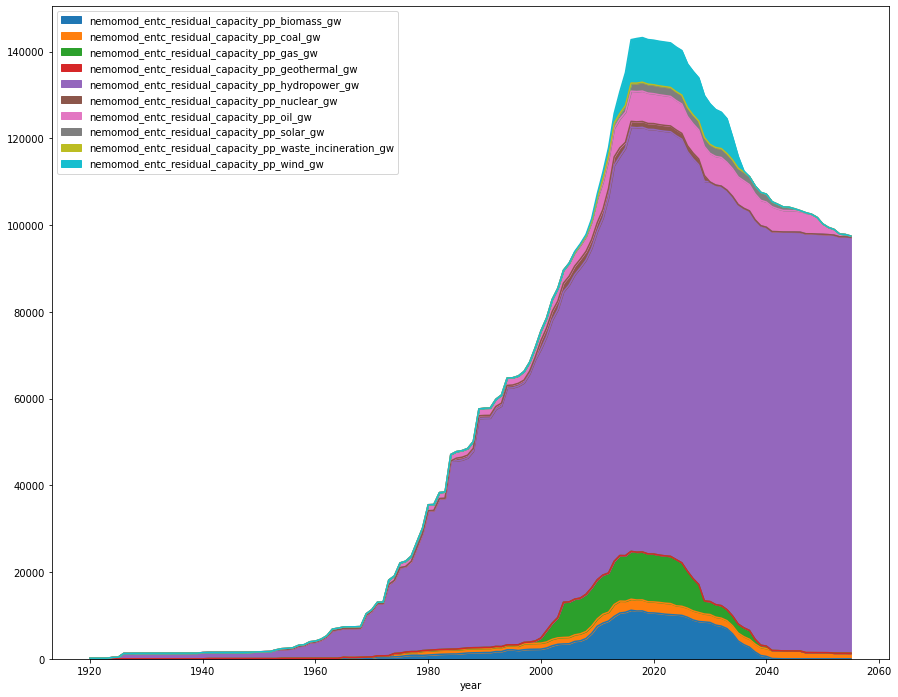

In [293]:
fig, ax = plt.subplots(figsize = (15, 12))
df_out_total[df_out_total["country"] == "brazil"][[x for x in df_out_total.columns if (x not in ["country"])]].plot.area(x = "year", ax = ax)


In [185]:
pd.pivot(
    df_years_out,
    ["year"],
    ["plant"]
)

,year,plant,capacity
0,1920,0,0.0
1,1921,0,0.0
2,1922,0,0.0
3,1923,0,0.0
4,1924,0,0.0
...,...,...,...
170,2051,pp_hydropower,17666.0
171,2052,pp_hydropower,17666.0
172,2053,pp_hydropower,17666.0
173,2054,pp_hydropower,17666.0
